# Multiple Linear Regression

Multiple linear regression is a statistical method that is used to model the linear relationship between a dependent variable and multiple independent variables. It is a type of regression analysis where the goal is to predict the value of a dependent variable based on the values of multiple independent variables. Let's apply this method in an example.

First of all, let's import the libraries and download and read the data: 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline

!wget -O FuelConsumption.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv

df = pd.read_csv("FuelConsumption.csv")
df.head() # let's see the first five rows of the dataset

--2024-01-25 19:44:29--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv
Resolviendo cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Conectando con cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)[169.45.118.108]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 72629 (71K) [text/csv]
Guardando como: ‘FuelConsumption.csv’

FuelConsumption.csv 100%[===================>]  70,93K  87,4KB/s    en 0,8s    

2024-01-25 19:44:32 (87,4 KB/s) - ‘FuelConsumption.csv’ guardado [72629/72629]



,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [3]:
# We only are going to consider the next rows:  ENGINESIZE , CYLINDERS, FUELCONSUMPTION_CITY, FUELCONSUMPTION_HWY , FUELCONSUMPTION_COMB, CO2EMISSIONS 
# to analyze some interesting correlation:

cdf = df[['ENGINESIZE', 'CYLINDERS' , 'FUELCONSUMPTION_CITY', 'FUELCONSUMPTION_HWY' , 'FUELCONSUMPTION_COMB', 'CO2EMISSIONS']]
cdf.head()

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,CO2EMISSIONS
0,2.0,4,9.9,6.7,8.5,196
1,2.4,4,11.2,7.7,9.6,221
2,1.5,4,6.0,5.8,5.9,136
3,3.5,6,12.7,9.1,11.1,255
4,3.5,6,12.1,8.7,10.6,244


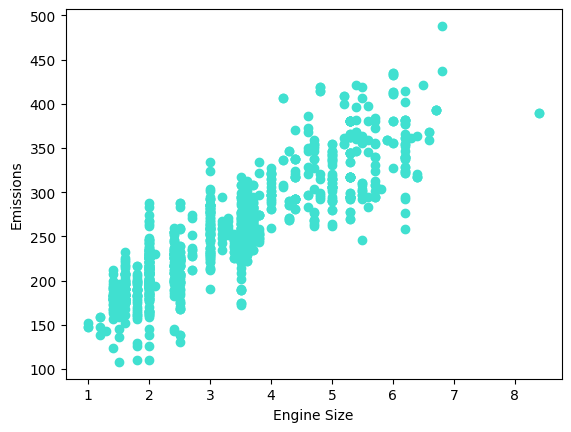

In [4]:
# Let's plot the correlation between ENGINESIZE and COEMISSIONS :
plt.scatter(cdf.ENGINESIZE, cdf.CO2EMISSIONS, color='turquoise')
plt.xlabel("Engine Size")
plt.ylabel("Emissions")
plt.show()

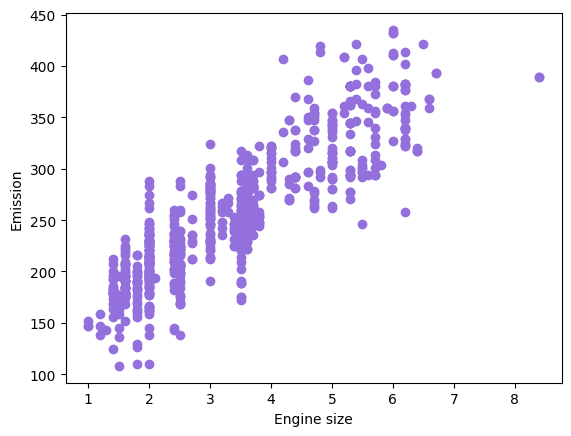

In [5]:
msk = np.random.rand(len(df)) < 0.8
train = cdf[msk]
test = cdf[~msk]

plt.scatter(train.ENGINESIZE, train.CO2EMISSIONS, color='mediumpurple')
plt.xlabel('Engine size')
plt.ylabel('Emission')
plt.show()

In [6]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_COMB']])
y = np.asanyarray(train[['CO2EMISSIONS']])
regr.fit(x,y)
print('Coefficients:', regr.coef_)


Coefficients: [[11.43939219  6.78904791  9.7594026 ]]


In [7]:
y_hat = regr.predict(test[['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_COMB']])
x = np.asanyarray(test[['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_COMB']])
y = np.asanyarray(test[['CO2EMISSIONS']])
print("Residual sum of squares: %.2f"% np.mean((y_hat - y)**2))
print('Variance score: %.2f' % regr.score(x, y))

Residual sum of squares: 614.63
Variance score: 0.85


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
